## Named Entity Identification using SVM

We will be using a SVM classifer for NEI task on CoNLL dataset with appropriate feature engineering.

## Dataset

CoNLL NER dataset

In [ ]:
%%capture
!python3 -m pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("conllpp")

Downloading:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/141k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conllpp downloaded and prepared to /root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset = {'train':[{'id':x['id'],'tokens':x['tokens'],'ner_tags':x['ner_tags']} for x in dataset['train']],'test':[{'id':x['id'],'tokens':x['tokens'],'ner_tags':x['ner_tags']} for x in dataset['test']]}
print(dataset['train'][0])
train_data = [(x['tokens'],x['ner_tags']) for x in dataset['train']]

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [ ]:
# print(len(dataset['train']))
# print(dataset['train'][0]['tokens'][0])
sent = dataset['train'][0]
word = sent['tokens'][0]
print(sent)
print(word)

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
EU


##Data Exploration

Here lets explore how skewed the data is.
We can expect data to be skewed as most of words will not be entities. Let us compute percentage of words as entities in each sentence and then lets explore number of sentences and % of entities in each sentence.

Refer to Data agumentation segemnet where we dealt with this problem of skewedness.

In [ ]:
percentage_dict = [0 for _ in range(101)]
percentage_indices = [[] for _ in range(101)]
for sent in dataset['train']:
    tags = sent['ner_tags']
    percent = 100-(tags.count(0)*100)//len(tags)
    percentage_dict[percent]+=1
    percentage_indices[percent].append(int(sent['id']))

In [ ]:
#print(*[(i,j) for i,j in percentage_dict.items()],sep='\n')
from matplotlib import pyplot as plt
%matplotlib inline

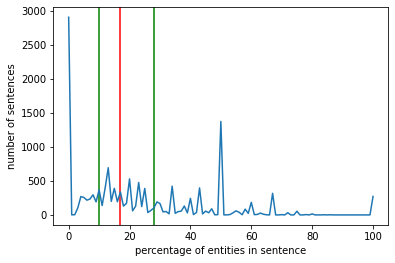

Number of sentence with more than 50% of words as entites is 2560


In [ ]:
total_sents = sum(percentage_dict)
sent_count = half = third = two_third = 0

for i in range(0,101):
    sent_count += percentage_dict[i]
    if not two_third:
        if sent_count > total_sents * 2/3:
            two_third = i
        if not half:
            if sent_count > total_sents * 1/2:
                half = i
            if not third:
                if sent_count > 1/3*total_sents:
                    third = i
plt.axvline(x=third,label='0.33 percentile',color='g')
plt.axvline(x=half,label='0.5 percentile',color='r')
plt.axvline(x=two_third,label='0.66 percentile',color='g')
plt.plot(percentage_dict)
plt.xlabel('percentage of entities in sentence')
plt.ylabel('number of sentences')
plt.show()
print(f'Number of sentence with more than 50% of words as entites is {sum(percentage_dict[50:])}')

## Data augumentation
For normalising the training data, lets just append more of the sentences with larger percentage of entities at the end of training data. So, instead of appending them now, lets append the them at features directly. But, we have only 2560 of these sentences in contrast to 14,000 in total. So lets append them twice.
Skip this part to get results at the end (in Notes)

In [ ]:
ind = len(dataset['train'])-1
duplicate_data = []
print(ind)
for i in range(50,101):
    for j in percentage_indices[i]:
        new_element = dataset['train'][j]
        ind+=1
        new_element['id'] = ind
        dataset['train'].append(new_element)
        ind+=1
        new_element['id'] = ind
        dataset['train'].append(new_element)
print(len(dataset['train']))

14040


NameError: ignored

# Feature Extraction

In [ ]:
%%capture
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
# featurs -> pos_tag, chunk_tag??, is_capital, is_starting?, prev word data?, next word data?, suffix?

In [ ]:
def w2f(sentence,pos_tags,i):
  postag = pos_tags[i]
  word = sentence[i]
  lword = word.lower()
  #chunktag = sent['chunk_tags'][i]

  features = {
      'postag'  : str(postag),
      #'chunktag': str(chunktag),
      'istitle' : word.istitle(),
      'isupper' : word.isupper(),
      'length'  : len(word),
      'isdigit' : word.isdigit(),
      '1suffix' : lword[-1:],
      '2suffix' : lword[-2:],
      '3suffix' : lword[-3:],
      '4suffix' : lword[-4:],
      '1prefix' : lword[:1],
      '2prefix' : lword[:2],
      '3prefix' : lword[:3],
      '4prefix' : lword[:4]
  }

  if i > 0:
    prevword = sentence[i-1]
    prevpostag = pos_tags[i-1]
    #prevchunktag = sent['chunk_tags'][i-1]

    features.update({
        'prevpostag'  : str(prevpostag),
        #'prevchunktag': str(prevchunktag),
        #'prevword'    : prevword.lower(),
        'previsupper' : prevword.isupper(),
        'previstitle' : prevword.istitle(),
        'prevdigit'   : prevword.isdigit(),
        'begin'       : False
    })
  else:
    features.update({
        'begin' : True
    })

  if i < len(sentence)-1:
    nextword = sentence[i+1]
    nextpostag = pos_tags[i+1]
    #nextchunktag = sent['chunk_tags'][i+1]

    features.update({
        'nextpostag'  : str(nextpostag),
        #'nextchunktag': str(nextchunktag),
        #'nextword'    : nextword.lower(),
        'nextisupper' : nextword.isupper(),
        'nextistitle' : nextword.istitle(),
        'nextdigit'   : nextword.isdigit(),
        'end'         : False
    })
  else:
    features.update({
        'end' : True
    })
  return features

def s2f(sent):
  pos_tags = [x[1] for x in pos_tag(sent)]
  return [w2f(sent['tokens'],pos_tags,i) for i in range(len(sent['tokens']))]

def s2t(sent):
  return [1 if (ner_tag > 0) else 0 for ner_tag in sent['ner_tags']]

def w2t(sent,i):
  return 1 if (sent['ner_tags'][i] > 0) else 0

In [ ]:
print(len(dataset['train']))
print(len(dataset['test']))

19161
3453


In [ ]:
X_train,Ytrain = [],[]
for sent in dataset['train']:
    pos_tags = [x[1] for x in pos_tag(sent['tokens'])]
    for i in range(len(pos_tags)):
        X_train.append(w2f(sent['tokens'],pos_tags,i))
        Ytrain.append(w2t(sent,i))
print(len(X_train),len(Ytrain))
X_test,Ytest = [],[]
for sent in dataset['test']:
    pos_tags = [x[1] for x in pos_tag(sent['tokens'])]
    for i in range(len(pos_tags)):
        X_test.append(w2f(sent['tokens'],pos_tags,i))
        Ytest.append(w2t(sent,i))

229171 229171


In [ ]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
res = vec.fit_transform(X_train+X_test)
print(res.shape)
Xtrain = res[:len(Ytrain)]
Xtest = res[len(Ytrain):]
print(Xtrain.shape)
print(len(Ytrain))
print(Xtest.shape)
print(len(Ytest))

(275606, 35467)
(229171, 35467)
229171
(46435, 35467)
46435


In [ ]:
fvec1 = Xtrain[0]
print(fvec1)

  (0, 36)	1.0
  (0, 109)	1.0
  (0, 488)	1.0
  (0, 1303)	1.0
  (0, 4170)	1.0
  (0, 8929)	1.0
  (0, 17302)	1.0
  (0, 29239)	1.0
  (0, 35327)	1.0
  (0, 35328)	0.0
  (0, 35329)	0.0
  (0, 35330)	0.0
  (0, 35331)	1.0
  (0, 35332)	2.0
  (0, 35333)	0.0
  (0, 35334)	0.0
  (0, 35335)	0.0
  (0, 35373)	1.0
  (0, 35397)	1.0


# SVM

In [ ]:
from sklearn import svm

model = svm.SVC()
model.fit(Xtrain,Ytrain)

Ypred = model.predict(Xtest)

NameError: ignored

In [ ]:
from sklearn import metrics

print(model.fit_status_)

accuracy = metrics.accuracy_score(Ytest,Ypred)
precision = metrics.precision_score(Ytest,Ypred)
recall = metrics.recall_score(Ytest,Ypred)
f1score = (2*precision*recall/(precision+recall))
confusion_matix = metrics.confusion_matrix(Ytest,Ypred)
print(confusion_matix)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("f1score: ",f1score)

0
[[37723   454]
 [  292  7966]]
Accuracy:  0.9839345321417035
Precision:  0.9460807600950119
Recall:  0.9646403487527246
f1score:  0.9552704161170403


In [ ]:
def test_on_example(sentence):
    global model,vec
    test_example = []
    sentence = sentence.split()
    pos_tags = [x[1] for x in pos_tag(sentence)]
    for i in range(len(sentence)):
        test_example.append(vec.transform(w2f(sentence,pos_tags,i)))
    print(' '.join(map(str,[model.predict(x)[0] for x in test_example])))

In [ ]:
test_on_example("The State Bank of India is the largest bank in the country")

0 1 1 0 1 0 0 0 0 0 0 0


In [ ]:
test_on_example("Pushpak Bhattacharyya teaches us CS626")

1 1 0 0 1


In [ ]:
test_on_example("India got its independence in 15.8.47")

1 0 0 0 0 0


In [ ]:
test_on_example("I have been taking a course called CS626 by Prof. Pushpak Battacharyya ")

0 0 0 0 0 0 0 1 0 1 1 1


In [ ]:
test_on_example("There are many IT companies in San Fransisco")

NameError: ignored

Saving model to drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle
path_to_dir = '/content/gdrive/MyDrive/CS626-NLP-Assignments/A3-model'
save_model_path = path_to_dir+'/model.sav'
save_dict_vect_path = path_to_dir+'/dict-vect.sav'


In [ ]:
pickle.dump(model, open(save_model_path, 'wb'))
pickle.dump(vec, open(save_dict_vect_path, 'wb'))

In [ ]:
from sklearn import svm
from sklearn.feature_extraction import DictVectorizer
import nltk
from nltk.tag import pos_tag

model_saved = pickle.load(open(save_model_path, 'rb'))
vec_saved = pickle.load(open(save_dict_vect_path, 'rb'))

In [ ]:
def test_on_example_saved_model(sentence):
    global model_saved,vec_saved
    test_example = []
    sentence = sentence.split()
    pos_tags = [x[1] for x in pos_tag(sentence)]
    for i in range(len(sentence)):
        test_example.append(vec_saved.transform(w2f(sentence,pos_tags,i)))
    print(' '.join(map(str,[model_saved.predict(x)[0] for x in test_example])))

In [ ]:
test_on_example_saved_model('''1947 is the year of independence of India .''' )

0 0 0 0 0 0 0 1 0


# Notes

## Results Without data augmentation
Time : 15mins


status = 0

confusion matrix :

[

    [37747   430]
    [ 353   7905]
]


Accuracy:  0.9831377193926994


Precision:  0.9484103179364127


Recall:  0.9572535722935336


f1score:  0.9528114265051528








